In [ ]:
%%capture
!bash setup.sh "password"

In [4]:
import torch
import glob
import time
import numpy as np
import mmcv, cv2
from facenet_pytorch import MTCNN, InceptionResnetV1, extract_face
from PIL import Image, ImageDraw
from IPython import display
from tqdm import tqdm
from matplotlib import pyplot as plt

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cpu


# EDA

In [6]:
video = mmcv.VideoReader('data/train_sample_videos/avibnnhwhp.mp4')
frames = [Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)) for frame in video]

In [7]:
frames_tracked = []
detector = MTCNN()

for i, frame in enumerate(frames):
    if i % 10 == 0:
        print('\rTracking frame: {}'.format(i + 1), end='')
        # Detect faces
        boxes, prob, landmarks = detector.detect(frame, landmarks = True)

        # Draw faces
        frame_draw = frame.copy()
        draw = ImageDraw.Draw(frame_draw)
        
        # if multiple faces
        for box in boxes:
            draw.rectangle(box.tolist(), outline=(255, 0, 0), width=6)
        
        # if only the best one
        # box = boxes[np.argmax(prob)]  # pick the most likely faces, not sure if there is videos with more than 1 faces
        # draw.rectangle(box.tolist(), outline=(255, 0, 0), width=6)

        # Add to frame list
        frames_tracked.append(frame_draw.resize((640, 360), Image.BILINEAR))
print('\nDone')

Tracking frame: 291
Done


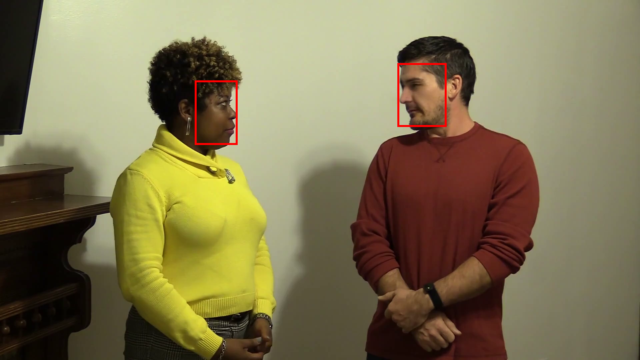

In [8]:
d = display.display(frames_tracked[0], display_id=True)
i = 1
try:
    while i <= len(frames_tracked):
        d.update(frames_tracked[i % len(frames_tracked)])
        i += 1
except KeyboardInterrupt:
    pass


In [ ]:
v_cap = cv2.VideoCapture('data/train_sample_videos/avibnnhwhp.mp4')

# Loop through video
batch_size = 32
frames = []
boxes = []
landmarks = []
view_frames = []
view_boxes = []
view_landmarks = []
v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))
mtcnn = MTCNN()
for _ in tqdm(range(v_len)):
    
    # Load frame
    success, frame = v_cap.read()
    if not success:
        continue
        
    # Add to batch, resizing for speed
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = Image.fromarray(frame)
    frame = frame.resize([int(f * 0.25) for f in frame.size])
    frames.append(frame)
    
    # When batch is full, detect faces and reset batch list
    if len(frames) >= batch_size:
        batch_boxes, _, batch_landmarks = mtcnn.detect(frames, landmarks=True)
        boxes.extend(batch_boxes)
        landmarks.extend(batch_landmarks)
        
        view_frames.append(frames[-1])
        view_boxes.append(boxes[-1])
        view_landmarks.append(landmarks[-1])
        
        frames = []

# Visualize
fig, ax = plt.subplots(3, 3, figsize=(18, 12))
for i in range(9):
    ax[int(i / 3), i % 3].imshow(view_frames[i])
    ax[int(i / 3), i % 3].axis('off')
    for box, landmark in zip(view_boxes[i], view_landmarks[i]):
        ax[int(i / 3), i % 3].scatter(*np.meshgrid(box[[0, 2]], box[[1, 3]]), s=8)
        ax[int(i / 3), i % 3].scatter(landmark[:, 0], landmark[:, 1], s=6)

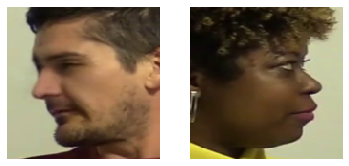

In [9]:
mtcnn = MTCNN(margin=40, keep_all=True, select_largest=False, post_process=False)

# Detect face
v_cap = cv2.VideoCapture('data/train_sample_videos/avibnnhwhp.mp4')
success, frame = v_cap.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
frame = Image.fromarray(frame)
faces = mtcnn(frame)

# Visualize
fig, axes = plt.subplots(1, len(faces))
for face, ax in zip(faces, axes):
    ax.imshow(face.permute(1, 2, 0).int().numpy())
    ax.axis('off')
fig.show()

100%|██████████| 300/300 [00:01<00:00, 209.69it/s]


2 faces detected


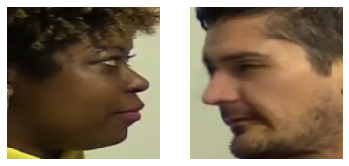

In [192]:
v_cap = cv2.VideoCapture('data/train_sample_videos/avibnnhwhp.mp4')  #avibnnhwhp, acifjvzvpm
v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))
mtcnn = MTCNN(margin=20, keep_all=True, post_process=False, thresholds = [0.9, 0.9, 0.9])

# Loop through video, taking a handful of frames to form a batch
frames = []
for i in tqdm(range(v_len)):
    
    # Load frame
    success = v_cap.grab()
    if i % 10 == 0:
        success, frame = v_cap.retrieve()
    else:
        continue
    if not success:
        continue
        
    # Add to batch
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frames.append(Image.fromarray(frame))

# Detect faces in batch
faces = mtcnn(frames)
print(str(np.max([len(faces[i]) for i in range(len(faces))])) + ' faces detected')

fig, axes = plt.subplots(1, np.max([len(faces[i]) for i in range(len(faces))]), figsize=(6, 15))
for j, face in enumerate(faces[np.argmax([len(faces[i]) for i in range(len(faces))])]):
    axes[j].imshow(face.permute(1,2,0).int().numpy())
    axes[j].axis('off')
fig.show()

# Load faces trial first

In [193]:
# Load face detector
mtcnn = MTCNN(margin=14, keep_all=True, post_process=False, thresholds = [0.9, 0.9, 0.9], device=device).eval()

# Load facial recognition model, but I didn't want to use it yet
resnet = InceptionResnetV1(pretrained='vggface2', device=device).eval()

In [194]:
class DetectionPipeline:
    """Pipeline class for detecting faces in the frames of a video file."""
    
    def __init__(self, detector, n_frames=None, batch_size=60, resize=None):
        """Constructor for DetectionPipeline class.
        
        Keyword Arguments:
            n_frames {int} -- Total number of frames to load. These will be evenly spaced
                throughout the video. If not specified (i.e., None), all frames will be loaded.
                (default: {None})
            batch_size {int} -- Batch size to use with MTCNN face detector. (default: {32})
            resize {float} -- Fraction by which to resize frames from original prior to face
                detection. A value less than 1 results in downsampling and a value greater than
                1 result in upsampling. (default: {None})
        """
        self.detector = detector
        self.n_frames = n_frames
        self.batch_size = batch_size
        self.resize = resize
    
    def __call__(self, filename):
        """Load frames from an MP4 video and detect faces.

        Arguments:
            filename {str} -- Path to video.
        """
        # Create video reader and find length
        v_cap = cv2.VideoCapture(filename)
        v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))

        # Pick 'n_frames' evenly spaced frames to sample
        if self.n_frames is None:
            sample = np.arange(0, v_len)
        else:
            sample = np.linspace(0, v_len - 1, self.n_frames).astype(int)

        # Loop through frames
        faces = []
        frames = []
        for j in range(v_len):
            success = v_cap.grab()
            if j in sample:
                # Load frame
                success, frame = v_cap.retrieve()
                if not success:
                    continue
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = Image.fromarray(frame)
                
                # Resize frame to desired size
                if self.resize is not None:
                    frame = frame.resize([int(d * self.resize) for d in frame.size])
                frames.append(frame)

                # When batch is full, detect faces and reset frame list
                if len(frames) % self.batch_size == 0 or j == sample[-1]:
                    faces.extend(self.detector(frames))
                    frames = []

        v_cap.release()

        return faces    


def process_faces(faces, resnet):
    # Filter out frames without faces
    faces = [f for f in faces if f is not None]
    faces = torch.cat(faces).to(device)

    # Generate facial feature vectors using a pretrained model
    embeddings = resnet(faces)

    # Calculate centroid for video and distance of each face's feature vector from centroid
    centroid = embeddings.mean(dim=0)
    x = (embeddings - centroid).norm(dim=1).cpu().numpy()
    
    return x

In [204]:
# Define face detection pipeline
detection_pipeline = DetectionPipeline(detector=mtcnn, batch_size=60, resize=0.25, n_frames=30)

# Get all test videos
filenames = glob.glob('data/train_sample_videos/*.mp4')

X = []
start = time.time()
n_processed = 0
with torch.no_grad():
    for i, filename in tqdm(enumerate(filenames), total=len(filenames)):
        try:
            # Load frames and find faces
            faces = detection_pipeline(filename)
            
            # Calculate embeddings
            X.append(faces)

        except KeyboardInterrupt:
            print('\nStopped.')
            break

        except Exception as e:
            print(e)
            X.append(None)
        
        n_processed += len(faces)
        print(f'Frames per second (load+detect+embed): {n_processed / (time.time() - start):6.3}\r', end='')

  0%|          | 1/400 [00:02<18:12,  2.74s/it]

  0%|          | 2/400 [00:05<18:04,  2.73s/it]

  1%|          | 3/400 [00:08<17:44,  2.68s/it]

  1%|          | 4/400 [00:10<17:34,  2.66s/it]

  1%|▏         | 5/400 [00:13<18:10,  2.76s/it]

  2%|▏         | 6/400 [00:15<17:08,  2.61s/it]

  2%|▏         | 7/400 [00:18<16:39,  2.54s/it]

  2%|▏         | 8/400 [00:20<16:26,  2.52s/it]

  2%|▏         | 9/400 [00:23<16:34,  2.54s/it]

  2%|▎         | 10/400 [00:25<16:23,  2.52s/it]

  3%|▎         | 11/400 [00:28<16:02,  2.47s/it]

  3%|▎         | 12/400 [00:30<16:00,  2.48s/it]

  3%|▎         | 13/400 [00:33<15:53,  2.46s/it]

  4%|▎         | 14/400 [00:35<15:54,  2.47s/it]

  4%|▍         | 15/400 [00:37<15:27,  2.41s/it]

  4%|▍         | 16/400 [00:40<16:24,  2.56s/it]

  4%|▍         | 17/400 [00:43<16:07,  2.53s/it]

  4%|▍         | 18/400 [00:45<16:07,  2.53s/it]

  5%|▍         | 19/400 [00:48<16:01,  2.52s/it]

  5%|▌         | 20/400 [00:50<15:52,  2.51s/it]

  5%|▌         | 21/400 [00:53<15:44,  2.49s/it]

  6%|▌         | 22/400 [00:55<15:50,  2.52s/it]

  6%|▌         | 23/400 [00:58<16:46,  2.67s/it]

  6%|▌         | 24/400 [01:01<16:32,  2.64s/it]

  6%|▋         | 25/400 [01:04<17:10,  2.75s/it]

  6%|▋         | 26/400 [01:06<15:33,  2.50s/it]

could not broadcast input array from shape (0,9) into shape (0)


  7%|▋         | 27/400 [01:09<16:58,  2.73s/it]

  7%|▋         | 28/400 [01:12<16:36,  2.68s/it]

  7%|▋         | 29/400 [01:14<16:48,  2.72s/it]

  8%|▊         | 30/400 [01:17<17:23,  2.82s/it]

  8%|▊         | 31/400 [01:20<16:27,  2.68s/it]

  8%|▊         | 32/400 [01:22<16:11,  2.64s/it]

  8%|▊         | 33/400 [01:25<16:03,  2.63s/it]

  8%|▊         | 34/400 [01:28<16:27,  2.70s/it]

  9%|▉         | 35/400 [01:30<15:41,  2.58s/it]

  9%|▉         | 36/400 [01:33<16:05,  2.65s/it]

  9%|▉         | 37/400 [01:36<16:06,  2.66s/it]

 10%|▉         | 38/400 [01:38<15:55,  2.64s/it]

 10%|▉         | 39/400 [01:41<15:25,  2.56s/it]

 10%|█         | 40/400 [01:43<15:24,  2.57s/it]

 10%|█         | 41/400 [01:46<15:42,  2.63s/it]

 10%|█         | 42/400 [01:49<15:34,  2.61s/it]

 11%|█         | 43/400 [01:51<15:28,  2.60s/it]

 11%|█         | 44/400 [01:54<15:26,  2.60s/it]

 11%|█▏        | 45/400 [01:56<15:15,  2.58s/it]

 12%|█▏        | 46/400 [01:59<15:05,  2.56s/it]

 12%|█▏        | 47/400 [02:01<15:16,  2.60s/it]

 12%|█▏        | 48/400 [02:04<15:06,  2.58s/it]

 12%|█▏        | 49/400 [02:07<15:14,  2.60s/it]

 12%|█▎        | 50/400 [02:09<14:45,  2.53s/it]

 13%|█▎        | 51/400 [02:11<14:41,  2.53s/it]

 13%|█▎        | 52/400 [02:14<14:45,  2.54s/it]

 13%|█▎        | 53/400 [02:17<16:00,  2.77s/it]

 14%|█▎        | 54/400 [02:21<16:36,  2.88s/it]

 14%|█▍        | 55/400 [02:23<15:48,  2.75s/it]

 14%|█▍        | 56/400 [02:25<15:20,  2.68s/it]

 14%|█▍        | 57/400 [02:28<15:50,  2.77s/it]

 14%|█▍        | 58/400 [02:31<15:14,  2.68s/it]

 15%|█▍        | 59/400 [02:34<15:14,  2.68s/it]

 15%|█▌        | 60/400 [02:37<15:40,  2.76s/it]

 15%|█▌        | 61/400 [02:39<15:04,  2.67s/it]

 16%|█▌        | 62/400 [02:42<15:04,  2.68s/it]

 16%|█▌        | 63/400 [02:45<15:29,  2.76s/it]

 16%|█▌        | 64/400 [02:47<15:30,  2.77s/it]

 16%|█▋        | 65/400 [02:50<14:53,  2.67s/it]

 16%|█▋        | 66/400 [02:52<14:37,  2.63s/it]

 17%|█▋        | 67/400 [02:55<14:08,  2.55s/it]

 17%|█▋        | 68/400 [02:57<13:57,  2.52s/it]

 17%|█▋        | 69/400 [03:00<13:38,  2.47s/it]

 18%|█▊        | 70/400 [03:02<13:52,  2.52s/it]

 18%|█▊        | 71/400 [03:05<13:27,  2.45s/it]

 18%|█▊        | 72/400 [03:07<13:24,  2.45s/it]

 18%|█▊        | 73/400 [03:10<13:39,  2.50s/it]

 18%|█▊        | 74/400 [03:12<13:47,  2.54s/it]

 19%|█▉        | 75/400 [03:15<13:35,  2.51s/it]

 19%|█▉        | 76/400 [03:18<14:24,  2.67s/it]

 19%|█▉        | 77/400 [03:20<13:58,  2.60s/it]

 20%|█▉        | 78/400 [03:23<13:45,  2.56s/it]

 20%|█▉        | 79/400 [03:26<14:36,  2.73s/it]

 20%|██        | 80/400 [03:28<14:10,  2.66s/it]

 20%|██        | 81/400 [03:31<13:53,  2.61s/it]

 20%|██        | 82/400 [03:34<14:11,  2.68s/it]

 21%|██        | 83/400 [03:36<14:13,  2.69s/it]

 21%|██        | 84/400 [03:39<13:45,  2.61s/it]

 21%|██▏       | 85/400 [03:41<13:26,  2.56s/it]

 22%|██▏       | 86/400 [03:44<14:00,  2.68s/it]

 22%|██▏       | 87/400 [03:47<13:49,  2.65s/it]

 22%|██▏       | 88/400 [03:49<13:08,  2.53s/it]

 22%|██▏       | 89/400 [03:51<12:36,  2.43s/it]

 22%|██▎       | 90/400 [03:54<12:38,  2.45s/it]

 23%|██▎       | 91/400 [03:56<12:39,  2.46s/it]

 23%|██▎       | 92/400 [03:59<13:12,  2.57s/it]

 23%|██▎       | 93/400 [04:01<13:03,  2.55s/it]

 24%|██▎       | 94/400 [04:04<13:13,  2.59s/it]

 24%|██▍       | 95/400 [04:07<13:16,  2.61s/it]

 24%|██▍       | 96/400 [04:09<12:54,  2.55s/it]

 24%|██▍       | 97/400 [04:12<12:45,  2.53s/it]

 24%|██▍       | 98/400 [04:14<12:32,  2.49s/it]

 25%|██▍       | 99/400 [04:17<12:45,  2.54s/it]

 25%|██▌       | 100/400 [04:19<12:34,  2.51s/it]

 25%|██▌       | 101/400 [04:22<12:39,  2.54s/it]

 26%|██▌       | 102/400 [04:25<13:32,  2.73s/it]

 26%|██▌       | 103/400 [04:27<13:12,  2.67s/it]

 26%|██▌       | 104/400 [04:30<13:27,  2.73s/it]

 26%|██▋       | 105/400 [04:33<13:10,  2.68s/it]

 26%|██▋       | 106/400 [04:35<12:35,  2.57s/it]

 27%|██▋       | 107/400 [04:38<12:39,  2.59s/it]

 27%|██▋       | 108/400 [04:40<12:27,  2.56s/it]

 27%|██▋       | 109/400 [04:43<12:24,  2.56s/it]

 28%|██▊       | 110/400 [04:45<12:08,  2.51s/it]

 28%|██▊       | 111/400 [04:47<11:15,  2.34s/it]

could not broadcast input array from shape (0,9) into shape (0)


 28%|██▊       | 112/400 [04:49<11:05,  2.31s/it]

 28%|██▊       | 113/400 [04:52<11:15,  2.36s/it]

 28%|██▊       | 114/400 [04:55<11:32,  2.42s/it]

 29%|██▉       | 115/400 [04:57<11:46,  2.48s/it]

 29%|██▉       | 116/400 [05:00<12:06,  2.56s/it]

 29%|██▉       | 117/400 [05:02<11:49,  2.51s/it]

 30%|██▉       | 118/400 [05:04<11:02,  2.35s/it]

could not broadcast input array from shape (0,5) into shape (0)


 30%|██▉       | 119/400 [05:07<11:06,  2.37s/it]

 30%|███       | 120/400 [05:09<11:25,  2.45s/it]

 30%|███       | 121/400 [05:12<11:10,  2.40s/it]

 30%|███       | 122/400 [05:14<11:23,  2.46s/it]

 31%|███       | 123/400 [05:17<11:58,  2.60s/it]

 31%|███       | 124/400 [05:19<11:13,  2.44s/it]

 31%|███▏      | 125/400 [05:22<11:14,  2.45s/it]

 32%|███▏      | 126/400 [05:24<10:34,  2.32s/it]

could not broadcast input array from shape (0,9) into shape (0)


 32%|███▏      | 127/400 [05:26<11:05,  2.44s/it]

 32%|███▏      | 128/400 [05:29<10:56,  2.42s/it]

 32%|███▏      | 129/400 [05:31<10:12,  2.26s/it]

could not broadcast input array from shape (0,9) into shape (0)


 32%|███▎      | 130/400 [05:33<10:18,  2.29s/it]

 33%|███▎      | 131/400 [05:36<10:32,  2.35s/it]

 33%|███▎      | 132/400 [05:38<10:48,  2.42s/it]

 33%|███▎      | 133/400 [05:41<10:52,  2.44s/it]

 34%|███▎      | 134/400 [05:43<10:42,  2.41s/it]

 34%|███▍      | 135/400 [05:46<11:03,  2.50s/it]

 34%|███▍      | 136/400 [05:48<10:56,  2.49s/it]

 34%|███▍      | 137/400 [05:50<10:30,  2.40s/it]

 34%|███▍      | 138/400 [05:53<11:18,  2.59s/it]

 35%|███▍      | 139/400 [05:56<11:38,  2.68s/it]

 35%|███▌      | 140/400 [05:59<12:24,  2.86s/it]

 35%|███▌      | 141/400 [06:02<11:53,  2.76s/it]

 36%|███▌      | 142/400 [06:04<11:26,  2.66s/it]

 36%|███▌      | 143/400 [06:07<11:14,  2.62s/it]

 36%|███▌      | 144/400 [06:10<11:31,  2.70s/it]

 36%|███▋      | 145/400 [06:12<11:06,  2.61s/it]

 36%|███▋      | 146/400 [06:15<11:42,  2.76s/it]

 37%|███▋      | 147/400 [06:18<11:38,  2.76s/it]

 37%|███▋      | 148/400 [06:21<11:45,  2.80s/it]

 37%|███▋      | 149/400 [06:24<11:20,  2.71s/it]

 38%|███▊      | 150/400 [06:26<11:12,  2.69s/it]

 38%|███▊      | 151/400 [06:29<10:50,  2.61s/it]

 38%|███▊      | 152/400 [06:31<10:46,  2.61s/it]

 38%|███▊      | 153/400 [06:33<09:46,  2.38s/it]

could not broadcast input array from shape (0,9) into shape (0)


 38%|███▊      | 154/400 [06:36<10:27,  2.55s/it]

 39%|███▉      | 155/400 [06:38<10:22,  2.54s/it]

 39%|███▉      | 156/400 [06:41<09:44,  2.40s/it]

could not broadcast input array from shape (0,9) into shape (0)


 39%|███▉      | 157/400 [06:43<09:53,  2.44s/it]

 40%|███▉      | 158/400 [06:45<09:19,  2.31s/it]

could not broadcast input array from shape (0,9) into shape (0)


 40%|███▉      | 159/400 [06:48<09:34,  2.38s/it]

 40%|████      | 160/400 [06:50<09:33,  2.39s/it]

 40%|████      | 161/400 [06:53<09:52,  2.48s/it]

 40%|████      | 162/400 [06:56<10:34,  2.67s/it]

 41%|████      | 163/400 [06:59<10:38,  2.69s/it]

 41%|████      | 164/400 [07:01<10:38,  2.71s/it]

 41%|████▏     | 165/400 [07:04<10:27,  2.67s/it]

 42%|████▏     | 166/400 [07:06<10:09,  2.61s/it]

 42%|████▏     | 167/400 [07:09<10:08,  2.61s/it]

 42%|████▏     | 168/400 [07:12<10:05,  2.61s/it]

 42%|████▏     | 169/400 [07:14<10:00,  2.60s/it]

 42%|████▎     | 170/400 [07:17<10:42,  2.79s/it]

 43%|████▎     | 171/400 [07:20<10:08,  2.66s/it]

 43%|████▎     | 172/400 [07:22<09:47,  2.58s/it]

 43%|████▎     | 173/400 [07:25<10:16,  2.72s/it]

 44%|████▎     | 174/400 [07:28<10:15,  2.72s/it]

 44%|████▍     | 175/400 [07:30<09:50,  2.62s/it]

 44%|████▍     | 176/400 [07:33<09:45,  2.61s/it]

 44%|████▍     | 177/400 [07:36<10:21,  2.79s/it]

 44%|████▍     | 178/400 [07:39<09:59,  2.70s/it]

 45%|████▍     | 179/400 [07:41<09:43,  2.64s/it]

 45%|████▌     | 180/400 [07:44<09:29,  2.59s/it]

 45%|████▌     | 181/400 [07:47<09:50,  2.70s/it]

 46%|████▌     | 182/400 [07:50<10:22,  2.86s/it]

 46%|████▌     | 183/400 [07:52<09:50,  2.72s/it]

 46%|████▌     | 184/400 [07:55<09:37,  2.67s/it]

 46%|████▋     | 185/400 [07:57<09:19,  2.60s/it]

 46%|████▋     | 186/400 [08:00<09:06,  2.56s/it]

 47%|████▋     | 187/400 [08:02<09:06,  2.57s/it]

 47%|████▋     | 188/400 [08:04<08:44,  2.47s/it]

 47%|████▋     | 189/400 [08:07<08:51,  2.52s/it]

 48%|████▊     | 190/400 [08:10<08:56,  2.55s/it]

 48%|████▊     | 191/400 [08:12<08:38,  2.48s/it]

 48%|████▊     | 192/400 [08:14<08:19,  2.40s/it]

 48%|████▊     | 193/400 [08:17<08:17,  2.40s/it]

 48%|████▊     | 194/400 [08:19<07:48,  2.27s/it]

could not broadcast input array from shape (0,9) into shape (0)


 49%|████▉     | 195/400 [08:21<08:04,  2.36s/it]

 49%|████▉     | 196/400 [08:24<08:08,  2.39s/it]

 49%|████▉     | 197/400 [08:26<08:22,  2.47s/it]

 50%|████▉     | 198/400 [08:29<08:30,  2.53s/it]

 50%|████▉     | 199/400 [08:31<08:07,  2.42s/it]

 50%|█████     | 200/400 [08:34<08:05,  2.43s/it]

 50%|█████     | 201/400 [08:36<08:02,  2.43s/it]

 50%|█████     | 202/400 [08:39<08:40,  2.63s/it]

 51%|█████     | 203/400 [08:41<08:06,  2.47s/it]

 51%|█████     | 204/400 [08:44<08:27,  2.59s/it]

 51%|█████▏    | 205/400 [08:47<08:15,  2.54s/it]

 52%|█████▏    | 206/400 [08:49<08:05,  2.50s/it]

 52%|█████▏    | 207/400 [08:52<08:21,  2.60s/it]

 52%|█████▏    | 208/400 [08:54<08:15,  2.58s/it]

 52%|█████▏    | 209/400 [08:57<08:02,  2.53s/it]

 52%|█████▎    | 210/400 [09:00<09:00,  2.84s/it]

 53%|█████▎    | 211/400 [09:03<08:43,  2.77s/it]

 53%|█████▎    | 212/400 [09:05<08:10,  2.61s/it]

 53%|█████▎    | 213/400 [09:08<07:56,  2.55s/it]

 54%|█████▎    | 214/400 [09:10<08:11,  2.64s/it]

 54%|█████▍    | 215/400 [09:13<07:59,  2.59s/it]

 54%|█████▍    | 216/400 [09:15<07:56,  2.59s/it]

 54%|█████▍    | 217/400 [09:18<07:55,  2.60s/it]

 55%|█████▍    | 218/400 [09:21<07:50,  2.58s/it]

 55%|█████▍    | 219/400 [09:23<07:42,  2.55s/it]

 55%|█████▌    | 220/400 [09:25<07:07,  2.37s/it]

could not broadcast input array from shape (0,9) into shape (0)


 55%|█████▌    | 221/400 [09:27<06:42,  2.25s/it]

could not broadcast input array from shape (0,5) into shape (0)


 56%|█████▌    | 222/400 [09:30<07:07,  2.40s/it]

 56%|█████▌    | 223/400 [09:32<07:20,  2.49s/it]

 56%|█████▌    | 224/400 [09:35<07:14,  2.47s/it]

 56%|█████▋    | 225/400 [09:37<07:06,  2.44s/it]

 56%|█████▋    | 226/400 [09:40<06:55,  2.39s/it]

 57%|█████▋    | 227/400 [09:42<07:06,  2.46s/it]

 57%|█████▋    | 228/400 [09:45<07:07,  2.48s/it]

 57%|█████▋    | 229/400 [09:47<07:06,  2.49s/it]

 57%|█████▊    | 230/400 [09:50<07:12,  2.55s/it]

 58%|█████▊    | 231/400 [09:52<07:02,  2.50s/it]

 58%|█████▊    | 232/400 [09:55<07:27,  2.66s/it]

 58%|█████▊    | 233/400 [09:58<07:19,  2.63s/it]

 58%|█████▊    | 234/400 [10:00<07:13,  2.61s/it]

 59%|█████▉    | 235/400 [10:03<07:08,  2.60s/it]

 59%|█████▉    | 236/400 [10:05<07:00,  2.56s/it]

 59%|█████▉    | 237/400 [10:08<06:49,  2.51s/it]

 60%|█████▉    | 238/400 [10:11<07:03,  2.62s/it]

 60%|█████▉    | 239/400 [10:14<07:10,  2.67s/it]

 60%|██████    | 240/400 [10:16<07:12,  2.70s/it]

 60%|██████    | 241/400 [10:18<06:31,  2.46s/it]

could not broadcast input array from shape (0,9) into shape (0)


 60%|██████    | 242/400 [10:21<06:33,  2.49s/it]

 61%|██████    | 243/400 [10:23<06:30,  2.49s/it]

 61%|██████    | 244/400 [10:26<06:32,  2.51s/it]

 61%|██████▏   | 245/400 [10:29<06:48,  2.64s/it]

 62%|██████▏   | 246/400 [10:32<07:00,  2.73s/it]

 62%|██████▏   | 247/400 [10:35<07:02,  2.76s/it]

 62%|██████▏   | 248/400 [10:37<06:53,  2.72s/it]

 62%|██████▏   | 249/400 [10:40<06:41,  2.66s/it]

 62%|██████▎   | 250/400 [10:42<06:26,  2.58s/it]

 63%|██████▎   | 251/400 [10:44<06:02,  2.43s/it]

 63%|██████▎   | 252/400 [10:47<06:03,  2.45s/it]

 63%|██████▎   | 253/400 [10:49<06:16,  2.56s/it]

 64%|██████▎   | 254/400 [10:52<06:29,  2.67s/it]

 64%|██████▍   | 255/400 [10:55<06:21,  2.63s/it]

 64%|██████▍   | 256/400 [10:57<06:05,  2.54s/it]

 64%|██████▍   | 257/400 [11:00<06:03,  2.54s/it]

 64%|██████▍   | 258/400 [11:02<06:00,  2.54s/it]

 65%|██████▍   | 259/400 [11:05<06:04,  2.58s/it]

 65%|██████▌   | 260/400 [11:08<05:58,  2.56s/it]

 65%|██████▌   | 261/400 [11:10<05:52,  2.53s/it]

 66%|██████▌   | 262/400 [11:12<05:37,  2.44s/it]

 66%|██████▌   | 263/400 [11:15<05:39,  2.48s/it]

 66%|██████▌   | 264/400 [11:17<05:32,  2.45s/it]

 66%|██████▋   | 265/400 [11:20<06:01,  2.68s/it]

 66%|██████▋   | 266/400 [11:23<05:56,  2.66s/it]

 67%|██████▋   | 267/400 [11:26<05:49,  2.63s/it]

 67%|██████▋   | 268/400 [11:28<05:37,  2.56s/it]

 67%|██████▋   | 269/400 [11:31<05:37,  2.57s/it]

 68%|██████▊   | 270/400 [11:33<05:41,  2.63s/it]

 68%|██████▊   | 271/400 [11:36<05:43,  2.67s/it]

 68%|██████▊   | 272/400 [11:39<05:38,  2.64s/it]

 68%|██████▊   | 273/400 [11:41<05:35,  2.64s/it]

 68%|██████▊   | 274/400 [11:44<05:26,  2.59s/it]

 69%|██████▉   | 275/400 [11:46<05:21,  2.57s/it]

 69%|██████▉   | 276/400 [11:49<05:13,  2.53s/it]

 69%|██████▉   | 277/400 [11:51<05:06,  2.49s/it]

 70%|██████▉   | 278/400 [11:54<05:04,  2.50s/it]

 70%|██████▉   | 279/400 [11:56<04:43,  2.35s/it]

could not broadcast input array from shape (0,9) into shape (0)


 70%|███████   | 280/400 [11:58<04:53,  2.44s/it]

 70%|███████   | 281/400 [12:01<04:52,  2.45s/it]

 70%|███████   | 282/400 [12:03<04:49,  2.45s/it]

 71%|███████   | 283/400 [12:06<04:52,  2.50s/it]

 71%|███████   | 284/400 [12:08<04:39,  2.41s/it]

 71%|███████▏  | 285/400 [12:11<04:40,  2.43s/it]

 72%|███████▏  | 286/400 [12:13<04:30,  2.37s/it]

 72%|███████▏  | 287/400 [12:15<04:32,  2.41s/it]

 72%|███████▏  | 288/400 [12:18<04:36,  2.47s/it]

 72%|███████▏  | 289/400 [12:20<04:34,  2.47s/it]

 72%|███████▎  | 290/400 [12:22<04:14,  2.31s/it]

could not broadcast input array from shape (0,9) into shape (0)


 73%|███████▎  | 291/400 [12:25<04:21,  2.40s/it]

 73%|███████▎  | 292/400 [12:28<04:33,  2.53s/it]

 73%|███████▎  | 293/400 [12:30<04:28,  2.51s/it]

 74%|███████▎  | 294/400 [12:33<04:22,  2.48s/it]

 74%|███████▍  | 295/400 [12:35<04:30,  2.58s/it]

 74%|███████▍  | 296/400 [12:38<04:25,  2.56s/it]

 74%|███████▍  | 297/400 [12:40<04:20,  2.53s/it]

 74%|███████▍  | 298/400 [12:43<04:19,  2.54s/it]

 75%|███████▍  | 299/400 [12:46<04:36,  2.74s/it]

 75%|███████▌  | 300/400 [12:49<04:31,  2.71s/it]

 75%|███████▌  | 301/400 [12:52<04:43,  2.86s/it]

 76%|███████▌  | 302/400 [12:54<04:27,  2.73s/it]

 76%|███████▌  | 303/400 [12:57<04:14,  2.63s/it]

 76%|███████▌  | 304/400 [13:00<04:14,  2.65s/it]

 76%|███████▋  | 305/400 [13:01<03:52,  2.45s/it]

could not broadcast input array from shape (0,9) into shape (0)


 76%|███████▋  | 306/400 [13:04<03:53,  2.49s/it]

 77%|███████▋  | 307/400 [13:06<03:44,  2.42s/it]

 77%|███████▋  | 308/400 [13:09<03:41,  2.41s/it]

 77%|███████▋  | 309/400 [13:11<03:46,  2.49s/it]

 78%|███████▊  | 310/400 [13:14<03:54,  2.60s/it]

 78%|███████▊  | 311/400 [13:17<03:53,  2.62s/it]

 78%|███████▊  | 312/400 [13:19<03:43,  2.54s/it]

 78%|███████▊  | 313/400 [13:22<03:42,  2.56s/it]

 78%|███████▊  | 314/400 [13:24<03:38,  2.54s/it]

 79%|███████▉  | 315/400 [13:27<03:39,  2.58s/it]

 79%|███████▉  | 316/400 [13:30<03:37,  2.59s/it]

 79%|███████▉  | 317/400 [13:32<03:33,  2.57s/it]

 80%|███████▉  | 318/400 [13:35<03:26,  2.52s/it]

 80%|███████▉  | 319/400 [13:37<03:31,  2.61s/it]

 80%|████████  | 320/400 [13:39<03:13,  2.42s/it]

could not broadcast input array from shape (0,9) into shape (0)


 80%|████████  | 321/400 [13:42<03:21,  2.55s/it]

 80%|████████  | 322/400 [13:45<03:24,  2.63s/it]

 81%|████████  | 323/400 [13:47<03:17,  2.56s/it]

 81%|████████  | 324/400 [13:50<03:15,  2.57s/it]

 81%|████████▏ | 325/400 [13:53<03:11,  2.55s/it]

 82%|████████▏ | 326/400 [13:55<03:03,  2.48s/it]

 82%|████████▏ | 327/400 [13:58<03:06,  2.55s/it]

 82%|████████▏ | 328/400 [14:00<03:04,  2.56s/it]

 82%|████████▏ | 329/400 [14:03<02:59,  2.52s/it]

 82%|████████▎ | 330/400 [14:05<02:54,  2.49s/it]

 83%|████████▎ | 331/400 [14:08<02:54,  2.53s/it]

 83%|████████▎ | 332/400 [14:10<02:52,  2.53s/it]

 83%|████████▎ | 333/400 [14:13<03:01,  2.71s/it]

 84%|████████▎ | 334/400 [14:16<02:57,  2.70s/it]

 84%|████████▍ | 335/400 [14:18<02:51,  2.64s/it]

 84%|████████▍ | 336/400 [14:21<02:38,  2.48s/it]

 84%|████████▍ | 337/400 [14:23<02:32,  2.42s/it]

 84%|████████▍ | 338/400 [14:25<02:30,  2.42s/it]

 85%|████████▍ | 339/400 [14:28<02:32,  2.50s/it]

 85%|████████▌ | 340/400 [14:30<02:30,  2.51s/it]

 85%|████████▌ | 341/400 [14:33<02:30,  2.55s/it]

 86%|████████▌ | 342/400 [14:36<02:28,  2.57s/it]

 86%|████████▌ | 343/400 [14:38<02:26,  2.58s/it]

 86%|████████▌ | 344/400 [14:40<02:16,  2.44s/it]

 86%|████████▋ | 345/400 [14:43<02:13,  2.43s/it]

 86%|████████▋ | 346/400 [14:45<02:11,  2.43s/it]

 87%|████████▋ | 347/400 [14:48<02:10,  2.46s/it]

 87%|████████▋ | 348/400 [14:50<02:08,  2.47s/it]

 87%|████████▋ | 349/400 [14:53<02:12,  2.59s/it]

 88%|████████▊ | 350/400 [14:55<02:04,  2.50s/it]

 88%|████████▊ | 351/400 [14:58<01:59,  2.44s/it]

 88%|████████▊ | 352/400 [15:01<02:02,  2.55s/it]

 88%|████████▊ | 353/400 [15:03<01:56,  2.47s/it]

 88%|████████▊ | 354/400 [15:05<01:52,  2.46s/it]

 89%|████████▉ | 355/400 [15:08<01:51,  2.47s/it]

 89%|████████▉ | 356/400 [15:10<01:49,  2.48s/it]

 89%|████████▉ | 357/400 [15:13<01:46,  2.47s/it]

 90%|████████▉ | 358/400 [15:15<01:38,  2.34s/it]

could not broadcast input array from shape (0,9) into shape (0)


 90%|████████▉ | 359/400 [15:17<01:38,  2.40s/it]

 90%|█████████ | 360/400 [15:20<01:36,  2.42s/it]

 90%|█████████ | 361/400 [15:22<01:34,  2.43s/it]

 90%|█████████ | 362/400 [15:25<01:36,  2.54s/it]

 91%|█████████ | 363/400 [15:28<01:33,  2.54s/it]

 91%|█████████ | 364/400 [15:30<01:34,  2.63s/it]

 91%|█████████▏| 365/400 [15:34<01:37,  2.78s/it]

 92%|█████████▏| 366/400 [15:36<01:30,  2.67s/it]

 92%|█████████▏| 367/400 [15:38<01:26,  2.62s/it]

 92%|█████████▏| 368/400 [15:41<01:22,  2.57s/it]

 92%|█████████▏| 369/400 [15:43<01:19,  2.56s/it]

 92%|█████████▎| 370/400 [15:46<01:15,  2.52s/it]

 93%|█████████▎| 371/400 [15:48<01:13,  2.52s/it]

 93%|█████████▎| 372/400 [15:51<01:15,  2.68s/it]

 93%|█████████▎| 373/400 [15:54<01:10,  2.63s/it]

 94%|█████████▎| 374/400 [15:57<01:09,  2.67s/it]

 94%|█████████▍| 375/400 [15:59<01:05,  2.64s/it]

 94%|█████████▍| 376/400 [16:02<01:03,  2.66s/it]

 94%|█████████▍| 377/400 [16:05<01:00,  2.62s/it]

 94%|█████████▍| 378/400 [16:07<00:56,  2.57s/it]

 95%|█████████▍| 379/400 [16:10<00:57,  2.74s/it]

 95%|█████████▌| 380/400 [16:13<00:54,  2.73s/it]

 95%|█████████▌| 381/400 [16:15<00:49,  2.58s/it]

 96%|█████████▌| 382/400 [16:17<00:44,  2.49s/it]

 96%|█████████▌| 383/400 [16:20<00:41,  2.46s/it]

 96%|█████████▌| 384/400 [16:22<00:38,  2.38s/it]

 96%|█████████▋| 385/400 [16:24<00:36,  2.43s/it]

 96%|█████████▋| 386/400 [16:27<00:34,  2.46s/it]

 97%|█████████▋| 387/400 [16:29<00:30,  2.31s/it]

could not broadcast input array from shape (0,9) into shape (0)


 97%|█████████▋| 388/400 [16:32<00:28,  2.39s/it]

 97%|█████████▋| 389/400 [16:34<00:26,  2.38s/it]

 98%|█████████▊| 390/400 [16:36<00:23,  2.36s/it]

 98%|█████████▊| 391/400 [16:39<00:21,  2.36s/it]

 98%|█████████▊| 392/400 [16:42<00:20,  2.57s/it]

 98%|█████████▊| 393/400 [16:44<00:17,  2.56s/it]

 98%|█████████▊| 394/400 [16:47<00:15,  2.61s/it]

 99%|█████████▉| 395/400 [16:50<00:13,  2.65s/it]

 99%|█████████▉| 396/400 [16:52<00:10,  2.58s/it]

 99%|█████████▉| 397/400 [16:54<00:07,  2.37s/it]

could not broadcast input array from shape (0,9) into shape (0)


100%|█████████▉| 398/400 [16:56<00:04,  2.43s/it]

100%|█████████▉| 399/400 [16:59<00:02,  2.48s/it]

100%|██████████| 400/400 [17:02<00:00,  2.48s/it]

In [219]:
for i, filename in enumerate(filenames):
    file = X[i]
    if file is not None:
        n_faces = np.max([frame.shape[0] for frame in file if frame is not None])
    else:
        n_faces = 0
    print(filename + " has " + str(n_faces))

data/train_sample_videos/dbhrpizyeq.mp4 has 1
data/train_sample_videos/ciyoudyhly.mp4 has 2
data/train_sample_videos/alvgwypubw.mp4 has 1
data/train_sample_videos/apogckdfrz.mp4 has 1
data/train_sample_videos/aagfhgtpmv.mp4 has 1
data/train_sample_videos/esyrimvzsa.mp4 has 1
data/train_sample_videos/acifjvzvpm.mp4 has 1
data/train_sample_videos/eqjscdagiv.mp4 has 1
data/train_sample_videos/drgjzlxzxj.mp4 has 2
data/train_sample_videos/cbltdtxglo.mp4 has 1
data/train_sample_videos/asaxgevnnp.mp4 has 1
data/train_sample_videos/cwsbspfzck.mp4 has 1
data/train_sample_videos/bgvhtpzknn.mp4 has 1
data/train_sample_videos/esgftaficx.mp4 has 1
data/train_sample_videos/dhjmzhrcav.mp4 has 1
data/train_sample_videos/dkuayagnmc.mp4 has 1
data/train_sample_videos/ctzmavwror.mp4 has 1
data/train_sample_videos/cprhtltsjp.mp4 has 1
data/train_sample_videos/byqzyxifza.mp4 has 1
data/train_sample_videos/bvzjkezkms.mp4 has 1
data/train_sample_videos/aknbdpmgua.mp4 has 1
data/train_sample_videos/bjkmjilrx

Pick some videos out to test the facial recognitions. 
`apatcsqejh.mp4` is the only one with 3 faces, but one is on a person's shirt......

Tracking frame: 291
Done


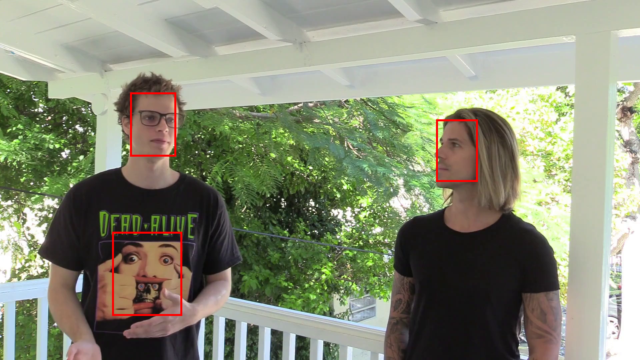

In [224]:
video = mmcv.VideoReader('data/train_sample_videos/apatcsqejh.mp4')
frames = [Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)) for frame in video]
frames_tracked = []
detector = MTCNN()

for i, frame in enumerate(frames):
    if i % 10 == 0:
        print('\rTracking frame: {}'.format(i + 1), end='')
        # Detect faces
        boxes, prob, landmarks = detector.detect(frame, landmarks = True)

        # Draw faces
        frame_draw = frame.copy()
        draw = ImageDraw.Draw(frame_draw)
        
        # if multiple faces
        for box in boxes:
            draw.rectangle(box.tolist(), outline=(255, 0, 0), width=6)
        
        # if only the best one
        # box = boxes[np.argmax(prob)]  # pick the most likely faces, not sure if there is videos with more than 1 faces
        # draw.rectangle(box.tolist(), outline=(255, 0, 0), width=6)

        # Add to frame list
        frames_tracked.append(frame_draw.resize((640, 360), Image.BILINEAR))
print('\nDone')
d = display.display(frames_tracked[0], display_id=True)
i = 1
try:
    while i <= len(frames_tracked):
        d.update(frames_tracked[i % len(frames_tracked)])
        i += 1
except KeyboardInterrupt:
    pass


# Reference
* https://github.com/timesler/facenet-pytorch/blob/master/examples/face_tracking.ipynb
* https://www.kaggle.com/timesler/guide-to-mtcnn-in-facenet-pytorch
* https://www.kaggle.com/timesler/facial-recognition-model-in-pytorch